In [1]:
import libsbml as sb # SBML integration
import numpy as np # for making arrays
import pandas as pd # for dataframe conversion
from pajek_tools import PajekWriter # for graphics
from pathlib import Path
import seaborn as sea
import matplotlib.pyplot as plt
import scipy

In [2]:
# NOTE: if running the below code gives the following error:
#   NDFrame.to_csv() got an unexpected keyword argument 'line_terminator'
# the problem is an outdated line in the pajek_tools package code.
#
# To fix it:
#   1. Open pajek_tools.py to edit the program
#       a. If you don't know where pajek_tools.py is, go to command line and enter:
#           pip show pajek-tools
#   2. On line 202, make the following change:
#       line_terminator="\n",   ->   lineterminator="\n",
#   3. Make the same change on line 219
#   4. Save the file
#   5. Restart the python kernel and run all scripts in this notebook again

In [30]:
# some info from literature
iJO1366_rxn_nums = 2283
ECC2_rxn_nums = 499


def connectreduce(SBMLfilename, networkname, numberofrxns, linkageCleaningProportion, showCleaningHistsBool, writebool):
    ## First: extract the relevent info from SBML file
    reader = sb.SBMLReader() # open the reader
    document = reader.readSBMLFromFile(Path('networks_from_literature/'+SBMLfilename)) # read the file into document
    model = document.getModel() # and extract the model from the file
    specieslist = model.getListOfSpecies() # get a list of all the species
    rxnslist = model.getListOfReactions() # and of all the reactions
    numspecies = len(specieslist.getListOfAllElements()) # number of species (non-unique; if 1 species is in two compartments it is recorded twice with 2 different SIDs)
    numrxns = numberofrxns
    speciesIDs = np.empty(numspecies,dtype=object) # prepare an array that stores only the IDs of every species
    for s in range(numspecies):
        speciesIDs[s] = specieslist.get(s).getId() # and add in all the IDs

    ## Making Connectivity Matrix
    connect = np.zeros((numspecies,numspecies)) # make an N x N connectivity matrix where N is the number of species/substrates. we will have that if two substrates with speciesIDs indices i and j are linked, connect[i,j] = connect[j,i] = 1; otherwise 0.
    for r in range(numrxns): # for every reaction
        rxn = rxnslist.get(r)
        numreacts = rxn.getNumReactants() # find the number of reactants
        numprods = rxn.getNumProducts() # and products
        if numreacts+numprods>1: # if there are links to record...
            substrates = np.empty(numreacts+numprods,dtype=int) # the total number of involved substrates will be reactants+products
            if numreacts>0: # if reactants are involved...
                for i in range(numreacts): # for every reactant...
                    species = rxn.getReactant(i).getSpecies() # store its species id
                    speciesindex = np.where(speciesIDs == species)[0][0] # store the corresponding speciesIDs index
                    substrates[i] = speciesindex # add the speciesIDs index to the list of substrates
            if numprods>0: # now do the same for products
                for i in range(numprods):
                    species = rxn.getProduct(i).getSpecies()
                    speciesindex = np.where(speciesIDs == species)[0][0]
                    substrates[i+numreacts] = speciesindex
            for i in np.arange(len(substrates)): # for each recorded substrate...
                linkindexes = np.delete(substrates,i) # make a list of the other recorded substrates
                for n in np.arange(len(linkindexes)): # and for each of them...
                    connect[substrates[i],linkindexes[n]] = 1 # put a '1' in the linkage cell corresponding to the two linked substrates

    if writebool:
        connectpd = pd.DataFrame(connect, columns = speciesIDs) # convert to dataframe for file saving
        connectpd.to_csv(Path('connectivity_matrices/'+networkname+'/'+networkname+'.csv')) # save the file!


    ## Performing Topological Reduction

    specieslinks = np.empty(len(speciesIDs),dtype=int)
    for row in np.arange(len(connect[:,0])):
        specieslinks[row] = sum(connect[row,:])

    nodecolors = np.empty(len(specieslinks),dtype=str)

    nodecolors[:] = 'a' # set all nodes to black

    for end in np.where(specieslinks==1)[0]: # for each node with only 1 link...
        prevnode = end
        node = np.where(connect[end,:]==1)[0][0] # find and jump to the single linked node
        nodelinkcount = specieslinks[node] # count the number of links
        while nodelinkcount==2: # as long as the present node has 2 links
            nodecolors[node] = 'g' # color the node green
            nodelinks = np.where(connect[node,:]==1)[0] # find the two connections
            nextnode = nodelinks[nodelinks != prevnode][0] # target the node you haven't been to yet
            prevnode = node # make the jump !
            node = nextnode
            nodelinkcount = specieslinks[node] # see how many links the new node has. if it's 2, repeat; if not, find the next node with only 1 link and start over

    for node in np.where(specieslinks==2)[0]: # look at all the 2-link nodes
        if nodecolors[node] != 'g': # if it's not green
            nodecolors[node] = 'u' # make it blue

    # coloring branching hairs green
    for bluenode in np.where(nodecolors=='u')[0]: # for each blue node
        if nodecolors[bluenode] != 'u': continue # make sure the node is still blue; if not, move on
        nodelinks = np.where(connect[bluenode,:]==1)[0] # find its links
        blueblacklinks = np.empty(0,dtype=int)
        for link in nodelinks:
            if nodecolors[link]=='u' or nodecolors[link]=='a': blueblacklinks = np.append(blueblacklinks,link)
        
        if len(blueblacklinks>0): # if any of the links are blue or black...
            blueblacklink = blueblacklinks[0] # pick the first one as the link
            connect[bluenode,blueblacklink] = connect[blueblacklink,bluenode] = 0 # sever the link

            # burning algorithm
            burnlabels = np.repeat(-1,len(speciesIDs)) # label all nodes -1
            burnlabels[bluenode] = 0 # except the starting node
            nodes = np.where(connect[bluenode,:]==1)[0] # find its singular remaining link
            stage = 1 # set the stage
            while len(nodes) > 0: # as long as you still have more nodes linked
                burnlabels[nodes] = stage # assign the nodes labels based on the current stage
                nextnodes = np.empty(0,dtype=int) # initialize a list for the next stage's nodes
                for node in nodes: # for each node in the stage...
                    burningnodelinks = np.where(connect[node,:]==1)[0] # find its links
                    if len(burningnodelinks[burnlabels[burningnodelinks]==-1])>0: # if it has unstaged links...
                        nextnodes = np.append(nextnodes,burningnodelinks[burnlabels[burningnodelinks]==-1]) # append its unstaged linked nodes to the list
                nodes = nextnodes # move to the next stage
                stage = stage+1 # and update the stage count

            if burnlabels[blueblacklink] > 0: # if the node on the other side of the severed link was burned (i.e. is still in the starting node's network)
                continue # it's not a hair separation! make no changes and move on
            else: # if we DID separate a hair
                burnedsize = len(burnlabels[burnlabels != -1])
                if burnedsize < 0.5*(len(burnlabels[burnlabels == -1])): # if the burned part is less than half the size of the unburned part (i.e., it's a hair)...
                    nodecolors[burnlabels != -1] = 'g' # make the burned nodes green
                else: # if the burned part is more than half the size of the unburned part (i.e., it's the network)
                    # repeat the burning algorithm, but on the other side of the severed link
                    burnlabels = np.repeat(-1,len(speciesIDs))
                    burnlabels[blueblacklink] = 0
                    nodes = np.where(connect[blueblacklink,:]==1)[0]
                    stage = 1
                    while len(nodes) > 0:
                        burnlabels[nodes] = stage
                        nextnodes = np.empty(0,dtype=int)
                        for node in nodes:
                            burningnodelinks = np.where(connect[node,:]==1)[0]
                            if len(burningnodelinks[burnlabels[burningnodelinks]==-1])>0:
                                nextnodes = np.append(nextnodes,burningnodelinks[burnlabels[burningnodelinks]==-1])
                        nodes = nextnodes
                        stage = stage+1
                    
                    nodecolors[burnlabels != -1] = 'g' # and make the new burned nodes green

            connect[bluenode,blueblacklink] = connect[blueblacklink,bluenode] = 1 # finally, retie the severed link
        # if none of the links to the bluenode were black or blue, move on to another blue node
        
    nodecolors[nodecolors == 'a'] = 'r' # make all the still-black nodes red
    # print('green nodes: '+str(len(np.where(nodecolors=='g')[0]))) # DBUG
    # print('blue nodes: '+str(len(np.where(nodecolors=='u')[0]))) # DBUG
    # print('red nodes: '+str(len(np.where(nodecolors=='r')[0]))) # DBUG

    # Note: for the two reduction steps below, I'm not sure what the supplemental material (p. 13) means by "store [the removed hairs/arcs] as separate small networks together with the label of the [node/two ends] they connect to." I'll skip this for now and see what it affects.

    # Half-reduction (removing hairs)
    connect_halfreduced = connect # make a copy of the adjacency matrix for the half-reduction
    # print('green nodes removed: '+str(len(np.where(nodecolors=='g')[0]))) # DBUG
    connect_halfreduced[nodecolors=='g', :] = 0 # sever all links with green nodes
    connect_halfreduced[:,nodecolors=='g'] = 0 # ^
    nodecolors_halfreduced = nodecolors # make an updated coloring...
    nodecolors_halfreduced[nodecolors=='g'] = '' # ...where green nodes are colorless

    # Full Reduction (removing arcs)
    connect_reduced = connect_halfreduced # make a copy of the half-reduced adjacency matrix for the full-reduction
    nodecolors_reduced = nodecolors_halfreduced # same for coloring
    # totredlinksmade = 0 # DBUG
    for bluenode in np.where(nodecolors_reduced=='u')[0]: # for each blue node
        if nodecolors_reduced[bluenode] != 'u': continue # make sure the node is still blue; if not, move on
        node = bluenode
        nodelinks = np.where(connect[bluenode,:]==1)[0]
        prevnode = nodelinks[0]
        redlinks = np.repeat(-1,2) # initialize the vector holding the two red ends of the arc
        while redlinks[1]<0: # as long as there is still an end to be found...
            nodelinks = np.where(connect[node,:]==1)[0] # find the current node's links
            nodelinkcolors = nodecolors[nodelinks] # and their colors
            if any(nodelinkcolors=='r'): # check to see if the node is linked to any red nodes. if so...
                rednodelinks = nodelinks[np.where(nodelinkcolors=='r')[0]] # store any linked nodes that are red
                if redlinks[0]<0: # if we haven't found the first arc-end yet
                    redlinks[0] = rednodelinks[0] # store a red node as the first arc-end
                else: redlinks[1] = rednodelinks[0] # if we have found the first arc-end, store the red node as the second end
                if len(rednodelinks)==2: # if the blue node is linked to 2 red nodes (i.e., it's a 1-node arc)...
                    redlinks[1] = rednodelinks[1] # store the other red node as the second arc-end
                    nodecolors_reduced[node] = 'p' # make the blue node purple
                    break # and break out of the while loop
                else: 
                    prevnode = redlinks[0] # otherwise, prep to move in the other direction
            else:
                nextnode = nodelinks[nodelinks != prevnode][0] # target the node we haven't visited yet (or the non-red node)
                nodecolors_reduced[node] = 'p' # set the current node to purple (for later removal)
                prevnode = node # make the jump!
                node = nextnode
        # now that both red arc-ends have been found...
        connect_reduced[redlinks[0],redlinks[1]] = connect_reduced[redlinks[1],redlinks[0]] = 1 # link the two ends
        # totredlinksmade = totredlinksmade+1 # DBUG
        # and move onto the next blue node
    # print('red nodes connected: '+str(totredlinksmade)) # DBUG
    # print('blue nodes removed: '+str(len(np.where(nodecolors=='p')[0]))) # DBUG
    nodecolors_reduced[nodecolors_reduced=='p'] = '' # make all purple (formerly blue) nodes colorless

    # question: where do the separated arcs and hairs factor back in? do they not factor into the clustering of figs 4A-C, only being involved in the 4D graphic?
    # for now i'll just assume they're discarded except for fig 4D:

    # remove all rows/columns of adjacency matrix pertaining to removed nodes
    connect_halfreduced = connect_halfreduced[np.where(nodecolors_halfreduced != '')[0],:]
    connect_halfreduced = connect_halfreduced[:,np.where(nodecolors_halfreduced != '')[0]]
    speciesIDs_halfreduced = speciesIDs[np.where(nodecolors_halfreduced != '')[0]]
    connect_reduced = connect_reduced[np.where(nodecolors_reduced != '')[0],:]
    connect_reduced = connect_reduced[:, np.where(nodecolors_reduced != '')[0]]
    speciesIDs_reduced = speciesIDs[np.where(nodecolors_reduced != '')[0]]

    # some extra cleaning for the reduced matrix, since that's what we'll be using
    linkedBool = np.empty(len(speciesIDs_reduced)) # make a boolean array for whether a substrate has any links at all
    for s in np.arange(len(speciesIDs_reduced)):
        linkedBool[s] = sum(connect_reduced[s,:])!=0

    propLinked = np.empty(len(speciesIDs_reduced)) # make an array for the proportion of links each substrate has out of the total number all substrates with links
    for s in np.arange(len(speciesIDs_reduced)):
        propLinked[s] = len(np.where(connect_reduced[s,:]==1)[0])/len(np.where(linkedBool)[0])

    connect_reduced_cleaned = connect_reduced[np.where((propLinked<linkageCleaningProportion)==linkedBool)[0],:] # make a copy of the reduced connectivity matrix where substrates are removed if they have (a) no links or (b) a proportion of links greater than the specified cutoff
    connect_reduced_cleaned = connect_reduced_cleaned[:,np.where((propLinked<linkageCleaningProportion)==linkedBool)[0]] # this is so the clustering isn't influenced by species that are involved in a large number of reactions (e.g., H2O, ATP, etc.) and thus aren't informative
    speciesIDs_reduced_cleaned = speciesIDs_reduced[np.where((propLinked<linkageCleaningProportion)==linkedBool)[0]] # clean the list of species IDs accordingly

    if showCleaningHistsBool: # if the given argument is True, make histograms for the linkage proportions before and after cleaning (this is to help visually choose a linkageCleaningProportion that cuts off outliers)
        plt.hist(propLinked,bins=100)
        plt.title('proportion of all '+networkname+' species linked per substrate, pre-cleaning')
        plt.xlabel('proportion of species linked per substrate')
        plt.ylabel('frequency')
        plt.show()

        newPropLinked = np.empty(len(connect_reduced_cleaned[0,:]))
        for s in np.arange(len(connect_reduced_cleaned[0,:])):
            newPropLinked[s] = len(np.where(connect_reduced_cleaned[s,:]==1)[0])/len(connect_reduced_cleaned[0,:])

        plt.hist(newPropLinked,bins=100)
        plt.title('proportion of '+networkname+' species linked, post-cleaning (substrates with linkage prop. over '+str(linkageCleaningProportion)+' removed)')
        plt.xlabel('proportion of species linked per substrate')
        plt.ylabel('frequency')
        plt.show()


    if writebool:
        connect_halfreduced_pd = pd.DataFrame(connect_halfreduced,columns=speciesIDs_halfreduced) # convert to dataframe for file saving
        connect_halfreduced_pd.to_csv(Path('connectivity_matrices/'+networkname+'/'+networkname+'_halfreduced.csv')) # save the file!

        connect_reduced_pd = pd.DataFrame(connect_reduced_cleaned,columns=speciesIDs_reduced_cleaned) # convert to dataframe for file saving
        connect_reduced_pd.to_csv(Path('connectivity_matrices/'+networkname+'/'+networkname+'_reduced.csv')) # save the file!

    ## Converting adjacency matrices to edgelists for Pajek graphics
    if writebool:
        connect_edgelist = np.empty((len(np.where(connect==1)[0]), 2),dtype=object) # initialize the array of edges
        nextedgerow = 0 # initialize the count
        for row in np.arange(len(connect[:,0])): # for each row of the connectivity matrix...
            for col in np.arange(len(connect[0,:])): # go through every cell
                if connect[row,col]==1: # if a link is found...
                    connect_edgelist[nextedgerow,0] = speciesIDs[row] # add the IDs of the linked species to the edgelist
                    connect_edgelist[nextedgerow,1] = speciesIDs[col]
                    nextedgerow = nextedgerow+1 # and move to the next row (of both the connectivity matrix and the edgelist)

        connect_edgelist_pd = pd.DataFrame(connect_edgelist,columns=["row", "column"]) # convert to a dataframe
        writer = PajekWriter(connect_edgelist_pd, # convert the dataframe to a correctly formatted edgelist for Pajek
                            directed=False,
                            citing_colname="row",
                            cited_colname="column")
        writer.write(Path('pajek_maps/'+networkname+'/'+networkname+'.net')) # save the file!
        
        # repeat the above for the two reduced matrices
        connect_halfreduced_edgelist = np.empty((len(np.where(connect_halfreduced==1)[0]), 2),dtype=object)
        nextedgerow = 0
        for row in np.arange(len(connect_halfreduced[:,0])):
            for col in np.arange(len(connect_halfreduced[0,:])):
                if connect_halfreduced[row,col]==1:
                    connect_halfreduced_edgelist[nextedgerow,0] = speciesIDs_halfreduced[row]
                    connect_halfreduced_edgelist[nextedgerow,1] = speciesIDs_halfreduced[col]
                    nextedgerow = nextedgerow+1
        connect_halfreduced_edgelist_pd = pd.DataFrame(connect_halfreduced_edgelist,columns=["row", "column"])
        writer = PajekWriter(connect_halfreduced_edgelist_pd,
                            directed=False,
                            citing_colname="row",
                            cited_colname="column")
        writer.write(Path('pajek_maps/'+networkname+'/'+networkname+'_halfreduced.net')) # save the file!


        connect_reduced_edgelist = np.empty((len(np.where(connect_reduced_cleaned==1)[0]), 2),dtype=object)
        nextedgerow = 0
        for row in np.arange(len(connect_reduced_cleaned[:,0])):
            for col in np.arange(len(connect_reduced_cleaned[0,:])):
                if connect_reduced_cleaned[row,col]==1:
                    connect_reduced_edgelist[nextedgerow,0] = speciesIDs_reduced_cleaned[row]
                    connect_reduced_edgelist[nextedgerow,1] = speciesIDs_reduced_cleaned[col]
                    nextedgerow = nextedgerow+1
        connect_reduced_edgelist_pd = pd.DataFrame(connect_reduced_edgelist,columns=["row", "column"])
        writer = PajekWriter(connect_reduced_edgelist_pd,
                            directed=False,
                            citing_colname="row",
                            cited_colname="column")
        writer.write(Path('pajek_maps/'+networkname+'/'+networkname+'_reduced.net')) # save the file!

    return connect, connect_halfreduced, connect_reduced_cleaned, speciesIDs, speciesIDs_halfreduced, speciesIDs_reduced_cleaned # finally: return the three connectivity matrices and species IDs!

con_iJO1366, conHR_iJO1366, conR_iJO1366, spIDs_iJO1366, spIDsHR_iJO1366, spIDsR_iJO1366 = connectreduce("iJO1366_SBML.xml", "iJO1366", iJO1366_rxn_nums, 1, False, False) # make last argument True if you want the matrices/networks to be saved to file
con_ECC2, conHR_ECC2, conR_ECC2, spIDs_ECC2, spIDsHR_ECC2, spIDsR_ECC2 = connectreduce("ECC2_SBML.xml", "ECC2", ECC2_rxn_nums, 0.125, False, False) # make last argument True if you want the matrices/networks to be saved to file


In [34]:
## Overlap Matrix
def overlap(connect):
    if type(connect)==np.ndarray: # if the input is just one connectivity matrix, make just one overlap matrix
        Ov = np.empty(np.shape(connect)) # initialize a matrix showing the overlap for each pair of species
        Ov[:] = np.nan # fill in nan vals to start with
        for row in np.arange(len(connect[:,0])): 
            for col in np.arange(len(connect[0,:])): # for every pair of two species...
                if not np.isnan(Ov[row,col]): continue # if an overlap value hasn't already been filled in...
                else:
                    numCommonNeighbors = sum((connect[row,:]==1)*(connect[:,col]==1)) # find the number of other substrates BOTH species are linked to
                    minlinks = np.min([sum(connect[row,:]==1), sum(connect[:,col]==1)]) # find the smaller of each species' total number of links
                    step = np.heaviside(connect[row,col],0) # calculate the value of the step function (=1 if the 2 species are linked; =0 otherwise)
                    Ov[row,col] = (numCommonNeighbors + step)/(minlinks + 1 - step) # and calculate the 2 species' overlap (equation from literature)
        return Ov
    elif type(connect)==list: # if the input is a list of connectivity matrices, do the same as above for each matrix in the list
        Ovs=[] # initialize a list of overlap matrices for their respective connectivity matrices
        for i in np.arange(len(connect)):
            conmat = connect[i]
            Ov = np.empty(np.shape(conmat))
            Ov[:] = np.nan
            for row in np.arange(len(conmat[:,0])):
                for col in np.arange(len(conmat[0,:])):
                    if not np.isnan(Ov[row,col]): continue # if an overlap value hasn't already been filled in...
                    else:
                        numCommonNeighbors = sum((conmat[row,:]==1)*(conmat[:,col]==1))
                        minlinks = np.min([sum(conmat[row,:]==1), sum(conmat[:,col]==1)])
                        step = np.heaviside(conmat[row,col],0)
                        Ov[row,col] = (numCommonNeighbors + step)/(minlinks + 1 - step)
            Ovs.append(Ov) # append each finished overlap matrix to the list
        return(Ovs) # return the list of matrices
    else: print('argument must be a matrix or list of matrices') # dummy!

# ovp_iJO1366, ovpR_iJO1366 = overlap([con_iJO1366, conR_iJO1366]) # takes like 40mins
# ovp_ECC2, ovpR_ECC2 = overlap([con_ECC2, conR_ECC2])
    
# # write to file (so we don't have to run this long-ass thing every time)
# ovp_iJO1366_pd = pd.DataFrame(ovp_iJO1366,columns=spIDs_iJO1366) # convert to dataframe for file saving
# ovp_iJO1366_pd.to_csv(Path('overlap_matrices/iJO1366/iJO1366.csv')) # save the file!

# ovpR_iJO1366_pd = pd.DataFrame(ovpR_iJO1366,columns=spIDsR_iJO1366) # convert to dataframe for file saving
# ovpR_iJO1366_pd.to_csv(Path('overlap_matrices/iJO1366/iJO1366_reduced.csv')) # save the file!

# ovp_ECC2_pd = pd.DataFrame(ovp_ECC2,columns=spIDs_ECC2) # convert to dataframe for file saving
# ovp_ECC2_pd.to_csv(Path('overlap_matrices/ECC2/ECC2.csv')) # save the file!

# ovpR_ECC2_pd = pd.DataFrame(ovpR_ECC2,columns=spIDsR_ECC2) # convert to dataframe for file saving
# ovpR_ECC2_pd.to_csv(Path('overlap_matrices/ECC2/ECC2_reduced.csv')) # save the file!

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


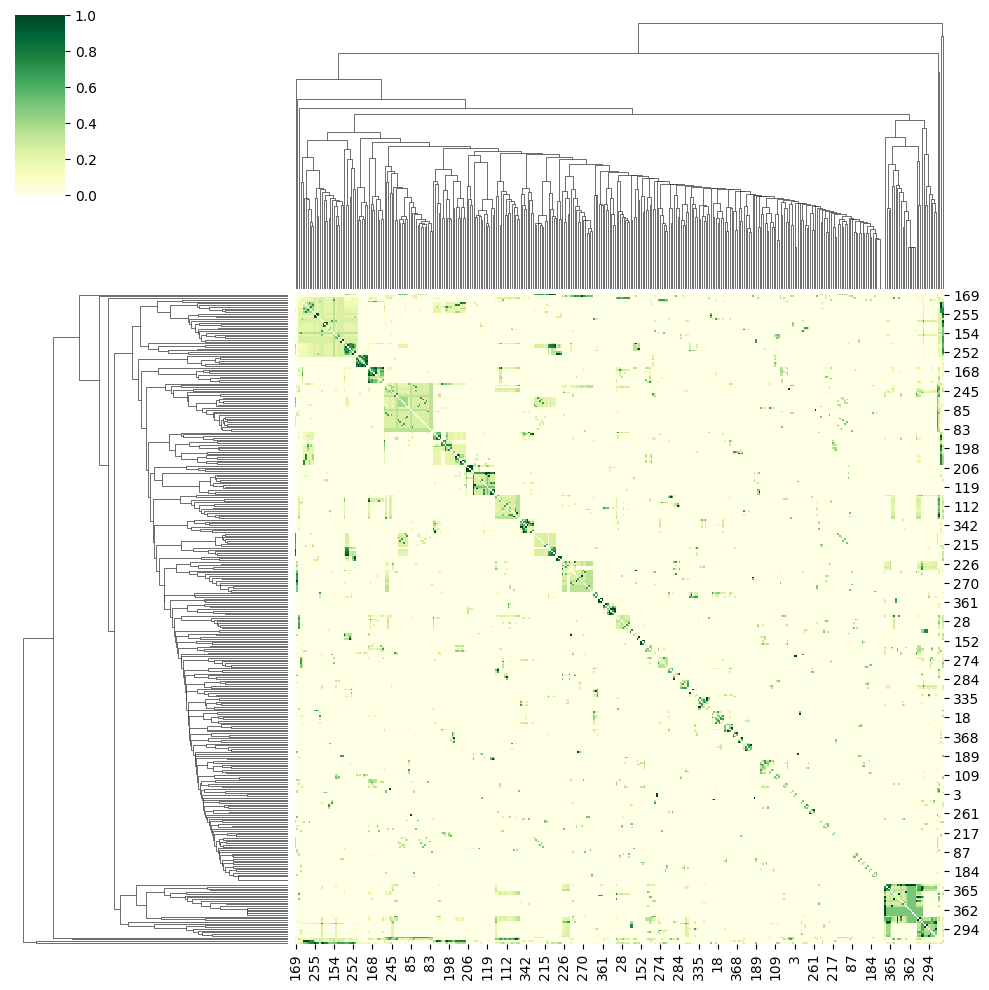

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


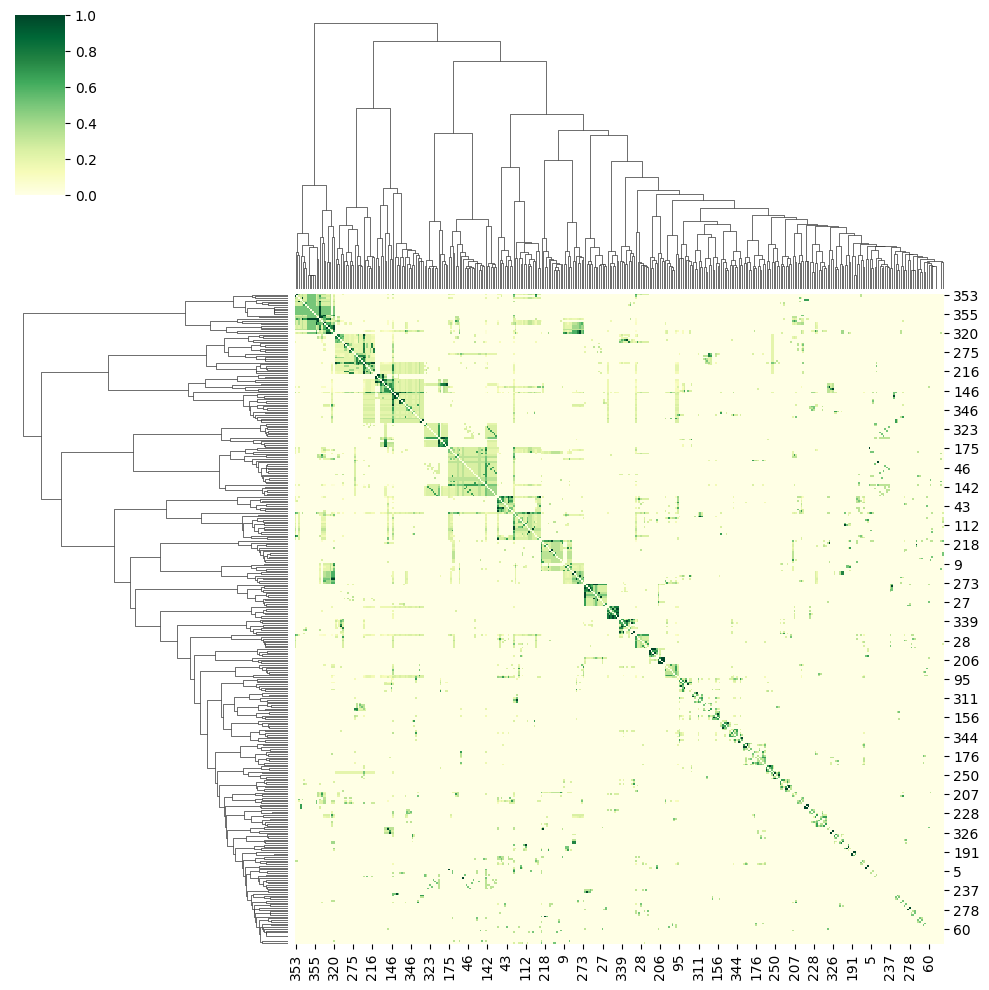

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


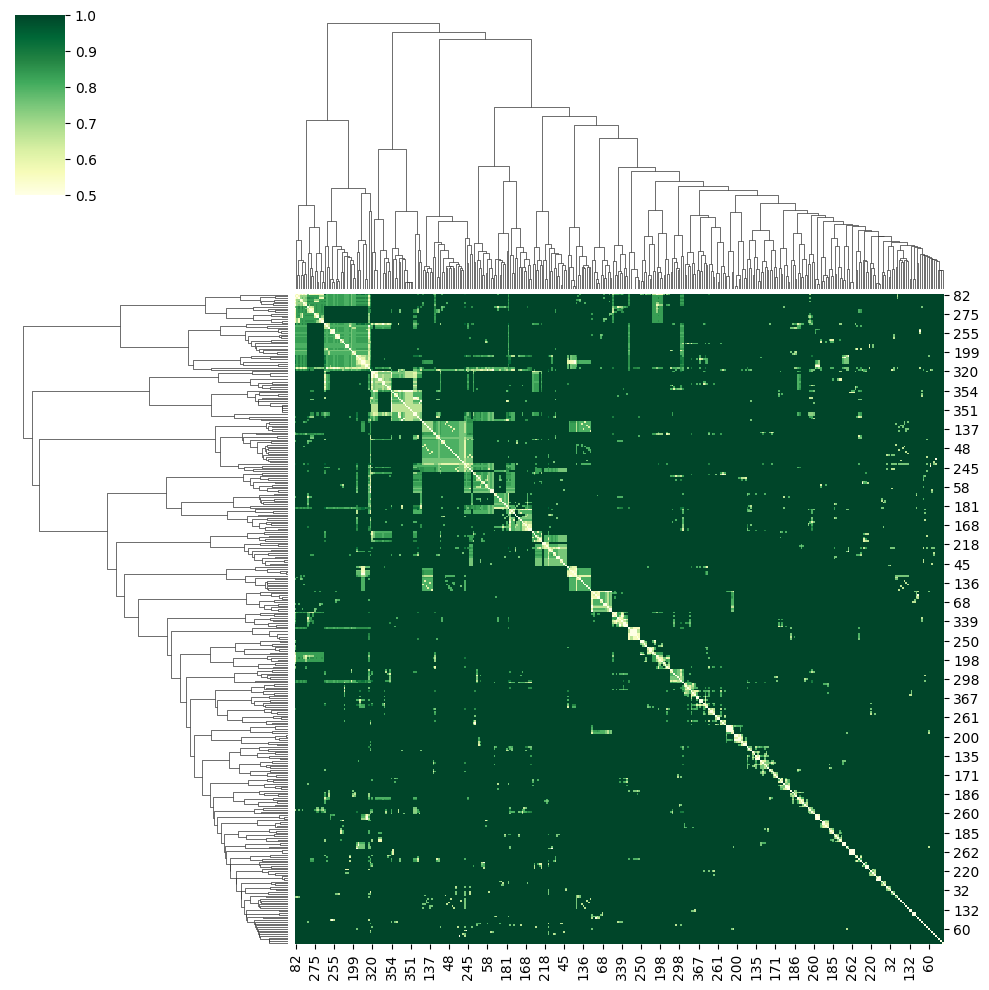

In [44]:
ovpR_ECC2 = pd.read_csv(Path('overlap_matrices/ECC2/ECC2_reduced.csv')).to_numpy()[:,1:]

for i in np.arange(len(ovpR_ECC2[:,0])):
    ovpR_ECC2[i,i] = 0

sea.heatmap(ovpR_ECC2,cmap='YlGn')
plt.show()
sea.clustermap(ovpR_ECC2,method="average",cmap='YlGn',dendrogram_ratio=(.3))  # the one used by the paper (UMPGA)
plt.show()
sea.clustermap(ovpR_ECC2,method="ward",cmap='YlGn',dendrogram_ratio=(.3)) # alternative method (ward)
plt.show()

# doesn't ward look much more separable? maybe should use that?

# need the biochemical classes per substrate to compare with clusters. no idea how to get that!!!